In [95]:
import pandas as pd
import numpy as np
import statsmodels.api as sm # needed for regression analysis
import scipy.stats as stats # needed for t-test
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer # needed for cosine similarity measure
from sklearn.metrics.pairwise import cosine_similarity # needed for cosine similarity measure

import os
import re
from tqdm import tqdm

# The Case of Baxter

I start my analysis with the case of Baxter Inc. Baxter Inc., whose stock fell by over 20% within two weeks following April 23, 2010. This crash is suggested to be only a late response to the significant textual changes in 10-K report for 2009 relative to 2008. 


In [3]:
# Load LM data and extract the 10-K files 
folder_path = '/Users/mertergin/Desktop/FinAIProject/EDGAR/QTR1_8_12_bax' # this folder includes all 10-X files from 2008 to 2012

# To store the 10-K files
df_bax = pd.DataFrame(columns=['report_year','filed_year', 'CIK', 'text'])

# Loop over all 10-K files
for filename in tqdm(os.listdir(folder_path), total=len(os.listdir(folder_path)), desc="Processing"):
    if filename.endswith('.txt') and '10-K' in filename and '10-K-A' not in filename: # exclude amendments
        # Extract year (first 4 characters)
        filed_year = int(filename[:4])
        
        # Extract CIK (its expected to come after 'data_')
        try:
            CIK_part = filename.split('data_')[1]
            CIK = CIK_part.split('_')[0]
        except:
            # If it cannot be found after data_
            print('CIK is not found!')

        # Read the file
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            
        # Extract report year
        # First 4 digits came after 'CONFORMED PERIOD OF REPORT' is the year reported for
        match_report = re.search(r'CONFORMED PERIOD OF REPORT:\s*(\d{8})', text)
        if match_report:
            report_year = match_report.group(1)
            report_year = int(report_year[:4]) # Take first 4 digits
        else:
            report_year = None
        
        df_bax.loc[len(df_bax)] = [report_year, filed_year, CIK, text]
                
print('Nb of rows: ', len(df_bax))
df_bax = df_bax.sort_values('report_year')
df_bax

Processing: 100%|████████████████████████████████| 6/6 [00:00<00:00, 462.25it/s]

Nb of rows:  5


,report_year,filed_year,CIK,text
2,2007,2008,10456,<Header>\n<FileStats>\n <FileName>20080226_...
4,2008,2009,10456,<Header>\n<FileStats>\n <FileName>20090219_...
3,2009,2010,10456,<Header>\n<FileStats>\n <FileName>20100223_...
1,2010,2011,10456,<Header>\n<FileStats>\n <FileName>20110223_...
0,2011,2012,10456,<Header>\n<FileStats>\n <FileName>20120223_...


In [4]:
# Match CIK with tickers using https://www.sec.gov/include/ticker.txt
ticker_map = pd.read_csv('/Users/mertergin/Desktop/FinAIProject/EDGAR/ticker.txt', sep='\t', names=['ticker', 'CIK'])

# Make sure CIKs are strings
ticker_map['CIK'] = ticker_map['CIK'].astype(str)
df_bax['CIK'] = df_bax['CIK'].astype(str)

# Merge
df_bax = df_bax.merge(ticker_map)
df_bax.head()

,report_year,filed_year,CIK,text,ticker
0,2007,2008,10456,<Header>\n<FileStats>\n <FileName>20080226_...,bax
1,2008,2009,10456,<Header>\n<FileStats>\n <FileName>20090219_...,bax
2,2009,2010,10456,<Header>\n<FileStats>\n <FileName>20100223_...,bax
3,2010,2011,10456,<Header>\n<FileStats>\n <FileName>20110223_...,bax
4,2011,2012,10456,<Header>\n<FileStats>\n <FileName>20120223_...,bax


In [5]:
# Calculate jaccard similarity measures between successive 10-Ks as in the paper

# Define a function for jaccard similarity
def jaccard_similarity(text1: str, text2: str) -> float:
    # Tokenize and convert to sets of unique words
    words1 = set(text1.lower().split())
    words2 = set(text2.lower().split())

    # Compute intersection and union
    intersection = words1.intersection(words2)
    union = words1.union(words2)

    return len(intersection) / len(union)
    
jaccard_sims_bax = []

texts = df_bax['text'].tolist()
years = df_bax['report_year'].tolist()

# Calculate cosine similarity between subsequent years
for i in range(len(texts) - 1):
    sim = jaccard_similarity(texts[i], texts[i+1])
    jaccard_sims_bax.append({
        'ticker' : 'bax',
        'report_year1': years[i],
        'report_year2': years[i+1],
        'similarity': sim
    })
# Create DataFrame with similarities
jaccard_sims_bax = pd.DataFrame(jaccard_sims_bax)

jaccard_sims_bax

,ticker,report_year1,report_year2,similarity
0,bax,2007,2008,0.647248
1,bax,2008,2009,0.649865
2,bax,2009,2010,0.693306
3,bax,2010,2011,0.689234


In [6]:
# Count FDA, Recall and Colleague Pump 
df_bax['fda_count'] = df_bax['text'].apply(lambda x: len(re.findall(r'\bfda\b', str(x), flags=re.IGNORECASE)))
df_bax['recall_count'] = df_bax['text'].apply(lambda x: len(re.findall(r'\brecalls?\b', str(x), flags=re.IGNORECASE)))
df_bax['colleague_count'] = df_bax['text'].apply(lambda x: len(re.findall(r'\bColleague\b', str(x), flags=re.IGNORECASE)))
df_bax

,report_year,filed_year,CIK,text,ticker,fda_count,recall_count,colleague_count
0,2007,2008,10456,<Header>\n<FileStats>\n <FileName>20080226_...,bax,33,16,29
1,2008,2009,10456,<Header>\n<FileStats>\n <FileName>20090219_...,bax,28,20,28
2,2009,2010,10456,<Header>\n<FileStats>\n <FileName>20100223_...,bax,26,14,27
3,2010,2011,10456,<Header>\n<FileStats>\n <FileName>20110223_...,bax,31,42,49
4,2011,2012,10456,<Header>\n<FileStats>\n <FileName>20120223_...,bax,26,45,52


# Main Analysis

Here I replicate the main analysis of Cohen et. al. 2020 on a more recent data set, 10-Ks from 2018 to 2024. 

1. I begin by loading the 10-K filings, CRSP stock return data, and one-month T-bill rates from local storage.
2. I then compute cosine and Jaccard similarity scores between consecutive 10-K filings for each firm.
3. Using these similarity measures, I construct a trading strategy that involves going long on firms with high textual similarity and short on those with low similarity.
4. Each filing is assigned to a similarity quintile based on its relative position within the month and year of filing, where Quintile 1 denotes low similarity and Quintile 5 high similarity.
5. I calculate average returns for portfolios holding each quintile for a three-month period and construct a corresponding long-short (Q5–Q1) portfolio.
6. As a robustness check, I also compute cumulative excess returns for one- and six-month holding periods across all quintiles.
7. Finally, I examine the relationship between similarity scores and future returns through regression analysis.


## 1. Load LM data

In [7]:
folder_path = '/Users/mertergin/Desktop/FinAIProject/EDGAR/QTR1_18_24' # this folder includes all 10-X files from 2018 to 2024

# To store the 10-K files
df = pd.DataFrame(columns=['report_year','filed_year','filed_date', 'CIK', 'text'])

# Loop over all 10-K files
for filename in tqdm(os.listdir(folder_path), total=len(os.listdir(folder_path)), desc="Processing"):
    if filename.endswith('.txt') and '10-K' in filename and '10-K-A' not in filename: # exclude amendments
        # Extract year (first 4 characters)
        filed_year = int(filename[:4])
        
        # Extract date (first 8 characters)
        filed_date = int(filename[:8])
        filed_date = pd.to_datetime(filed_date, format='%Y%m%d') # Convert to date time
        
        # Extract CIK (its expected to come after 'data_')
        try:
            CIK_part = filename.split('data_')[1]
            CIK = CIK_part.split('_')[0]
        except:
            # If it cannot be found after data_
            print('CIK is not found!')

        # Read the file
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            
        # Extract report year
        # First 4 digits came after 'CONFORMED PERIOD OF REPORT' is the year reported for
        match_report = re.search(r'CONFORMED PERIOD OF REPORT:\s*(\d{8})', text)
        if match_report:
            report_year = match_report.group(1)
            report_year = int(report_year[:4]) # Take first 4 digits
        else:
            report_year = None
        
        df.loc[len(df)] = [report_year, filed_year,filed_date, CIK, text]
                
print('Nb of rows: ', len(df))
df.head()

Processing: 100%|████████████████████████| 38460/38460 [01:28<00:00, 436.93it/s]


Nb of rows:  37151


,report_year,filed_year,filed_date,CIK,text
0,2020,2021,2021-03-25,1832010,<Header>\n<FileStats>\n <FileName>20210325_...
1,2021,2022,2022-02-23,912767,<Header>\n<FileStats>\n <FileName>20220223_...
2,2018,2019,2019-02-19,1047340,<Header>\n<FileStats>\n <FileName>20190219_...
3,2019,2020,2020-02-26,1655887,<Header>\n<FileStats>\n <FileName>20200226_...
4,2021,2022,2022-03-24,1830081,<Header>\n<FileStats>\n <FileName>20220324_...


In [8]:
# Exlude 10-Ks where filed year does not match the year reported for (filed year should be equal to report year plus one)
# If report year is not last year, then 10-K might be filed for amendments etc.
df = df[df['filed_year'] == df['report_year'] + 1]
print('Nb of rows: ', len(df))

df.head()

Nb of rows:  36135


,report_year,filed_year,filed_date,CIK,text
0,2020,2021,2021-03-25,1832010,<Header>\n<FileStats>\n <FileName>20210325_...
1,2021,2022,2022-02-23,912767,<Header>\n<FileStats>\n <FileName>20220223_...
2,2018,2019,2019-02-19,1047340,<Header>\n<FileStats>\n <FileName>20190219_...
3,2019,2020,2020-02-26,1655887,<Header>\n<FileStats>\n <FileName>20200226_...
4,2021,2022,2022-03-24,1830081,<Header>\n<FileStats>\n <FileName>20220324_...


In [9]:
# Obtain ticker for each CIK using https://www.sec.gov/include/ticker.txt
ticker_map = pd.read_csv('/Users/mertergin/Desktop/FinAIProject/EDGAR/ticker.txt', sep='\t', names=['ticker', 'CIK'])

# Make sure CIKs are strings
ticker_map['CIK'] = ticker_map['CIK'].astype(str)
df['CIK'] = df['CIK'].astype(str)

# Merge
df = df.merge(ticker_map)
df.head()

,report_year,filed_year,filed_date,CIK,text,ticker
0,2020,2021,2021-03-25,1832010,<Header>\n<FileStats>\n <FileName>20210325_...,omeg
1,2021,2022,2022-02-23,912767,<Header>\n<FileStats>\n <FileName>20220223_...,ufpi
2,2018,2019,2019-02-19,1047340,<Header>\n<FileStats>\n <FileName>20190219_...,fdp
3,2021,2022,2022-03-24,1830081,<Header>\n<FileStats>\n <FileName>20220324_...,cfvi
4,2021,2022,2022-03-24,1830081,<Header>\n<FileStats>\n <FileName>20220324_...,cfviu


In [10]:
# Load CRSP stock data.
crsp = pd.read_csv('/Users/mertergin/Desktop/FinAIProject/CRSP_stock_price_95-24.csv')

# Make sure column names and ticker names are lowercase
crsp.columns = crsp.columns.str.lower() 
crsp['ticker'] = crsp['ticker'].str.lower()
crsp = crsp[crsp['date'] > '2019-01-01']

# Delete rows where price is negative or zero. 
# In CRSP, a negative sign in price indicates that closing price is not available and bid/ask average is reported. 
# Zero price means neither closing price nor bid/ask average is available.
crsp = crsp[crsp['prc'] > 0]
crsp.head()

,permno,date,ticker,comnam,tsymbol,bidlo,askhi,prc,vol,ret,bid,ask,altprc,altprcdt
1491,10026,2019-01-31,jjsf,J & J SNACK FOODS CORP,JJSF,140.00,156.82001,154.35001,21310.0,0.067501,154.28999,154.31,154.35001,2019-01-31
1492,10026,2019-02-28,jjsf,J & J SNACK FOODS CORP,JJSF,152.69,159.74001,155.28000,14119.0,0.006025,155.28000,155.63,155.28000,2019-02-28
1493,10026,2019-03-29,jjsf,J & J SNACK FOODS CORP,JJSF,150.31,159.37000,158.84000,13216.0,0.026146,158.71001,158.92,158.84000,2019-03-29
1494,10026,2019-04-30,jjsf,J & J SNACK FOODS CORP,JJSF,152.50,157.17999,157.17999,14432.0,-0.010451,157.00999,157.17,157.17999,2019-04-30
1495,10026,2019-05-31,jjsf,J & J SNACK FOODS CORP,JJSF,158.55,165.67999,160.85001,15264.0,0.023349,160.85001,161.02,160.85001,2019-05-31


In [11]:
# Exclude firms which has no stock data in CRSP
tickers_crsp = pd.DataFrame(crsp['ticker'].drop_duplicates(), columns=['ticker'])

common_tickers = tickers_crsp.merge(ticker_map, on='ticker', how='inner')

df_common = df[df['ticker'].isin(common_tickers['ticker'])]

print('Nb of rows: ', len(df_common))

Nb of rows:  23130


In [12]:
# Load 1-month Treasury bill rate to use as risk-free interest rate. Needed to find excess returns.
# Data is obtained from https://fred.stlouisfed.org/series/DGS1MO
one_month_T_bill = pd.read_csv('/Users/mertergin/Desktop/FinAIProject/DGS1MO.csv')

# Rename columns for consistency
one_month_T_bill = one_month_T_bill.rename(columns={'observation_date': 'date','DGS1MO':'risk_free_rate'})

# Convert the daily data to monthly by using end-of-month value for consistency (I use monthly stock prices from CRSP too.)
one_month_T_bill['date'] = pd.to_datetime(one_month_T_bill['date'])
one_month_T_bill = one_month_T_bill.set_index('date')
one_month_T_bill = one_month_T_bill.resample('ME').last()
one_month_T_bill = one_month_T_bill.reset_index()

# Convert percental rate to decimal
one_month_T_bill['risk_free_rate'] = one_month_T_bill['risk_free_rate'] / 100

one_month_T_bill.head()

,date,risk_free_rate
0,2015-05-31,0.0001
1,2015-06-30,0.0002
2,2015-07-31,0.0004
3,2015-08-31,0.0000
4,2015-09-30,0.0000


## 2. Calculate Similarities

In [13]:
# Group by ticker 
grouped = df_common.groupby('ticker')
grouped.size()

ticker
aa      7
aaau    6
aac     2
aadi    7
aaic    6
       ..
zws     4
zy      1
zyme    5
zyne    6
zyxi    7
Length: 4588, dtype: int64

In [15]:
# Cosine Similarity
def sim_cosine(text1: str, text2: str) -> float:
    
    vectorizer = CountVectorizer() # Vectorizes the texts
    X = vectorizer.fit_transform([text1, text2]) # Term frequency vectors
    
    return cosine_similarity(X[0], X[1])[0][0]

cosine_sims = []

for ticker, group in tqdm(grouped, total=grouped.ngroups, desc="Processing"):
    
    group_sorted = group.sort_values('report_year')
    
    texts = group_sorted['text'].tolist()
    years = group_sorted['filed_year'].tolist()
    filed_dates = group_sorted['filed_date'].tolist()
    
    if len(texts) < 2:
        continue
    
    for i in range(len(texts) - 1):
        sim = sim_cosine(texts[i], texts[i+1])
        cosine_sims.append({
            'ticker' : ticker,
            'filed_year1': years[i],
            'filed_year2': years[i+1],
            'filed_date': filed_dates[i+1],
            'cosine_sim': sim
        })

# Create DataFrame with similarities
cosine_sims = pd.DataFrame(cosine_sims)
cosine_sims.head()

Processing: 100%|███████████████████████████| 4588/4588 [14:20<00:00,  5.33it/s]


,ticker,filed_year1,filed_year2,filed_date,cosine_sim
0,aa,2018,2019,2019-02-26,0.989516
1,aa,2019,2020,2020-02-21,0.992762
2,aa,2020,2021,2021-02-25,0.995696
3,aa,2021,2022,2022-02-24,0.971033
4,aa,2022,2023,2023-02-23,0.986027


In [129]:
# Jaccard Similarity
def jaccard_similarity(text1: str, text2: str) -> float:
    # Convert texts to sets of words
    words1 = set(text1.lower().split())
    words2 = set(text2.lower().split())

    # Compute intersection and union
    intersection = words1.intersection(words2)
    union = words1.union(words2)

    return len(intersection) / len(union)

jaccard_sims = []

for ticker, group in tqdm(grouped, total=grouped.ngroups, desc="Processing"):
    
    group_sorted = group.sort_values('report_year')
    
    texts = group_sorted['text'].tolist()
    years = group_sorted['filed_year'].tolist()
    filed_dates = group_sorted['filed_date'].tolist()
    
    if len(texts) < 2:
        continue
    
    for i in range(len(texts) - 1):
        sim = jaccard_similarity(texts[i], texts[i+1])
        jaccard_sims.append({
            'ticker' : ticker,
            'filed_year1': years[i],
            'filed_year2': years[i+1],
            'filed_date': filed_dates[i+1],
            'jaccard_sim': sim
        })

# Create DataFrame with similarities
jaccard_sims = pd.DataFrame(jaccard_sims)

Processing: 100%|███████████████████████████| 4588/4588 [04:29<00:00, 17.01it/s]


In [19]:
# Make one large dataframe with all types of similarity measures
df_sims = df_common.merge(cosine_sims, left_on=['ticker','filed_date'], right_on=['ticker','filed_date'], how='inner')

df_sims = df_sims.merge(jaccard_sims, left_on=['ticker','filed_date','filed_year1','filed_year2'], 
                   right_on=['ticker','filed_date','filed_year1','filed_year2'], how='inner')
df_sims.head()


,report_year,filed_year,filed_date,CIK,text,ticker,filed_year1,filed_year2,cosine_sim,jaccard_sim
0,2021,2022,2022-02-23,912767,<Header>\n<FileStats>\n <FileName>20220223_...,ufpi,2021,2022,0.957419,0.725166
1,2018,2019,2019-02-19,1047340,<Header>\n<FileStats>\n <FileName>20190219_...,fdp,2018,2019,0.950996,0.581421
2,2021,2022,2022-02-18,1482512,<Header>\n<FileStats>\n <FileName>20220218_...,hpp,2021,2022,0.988148,0.657114
3,2021,2022,2022-02-24,1253176,<Header>\n<FileStats>\n <FileName>20220224_...,vapo,2021,2022,0.971248,0.627646
4,2022,2023,2023-02-15,1282637,<Header>\n<FileStats>\n <FileName>20230215_...,neu,2022,2023,0.917477,0.603211


## 3. Build trading strategy

In [20]:
# Obtain the year and month that 10-K filed in. Needed for the portfolio construction.
# As there are too few companies that file in january, I put them into february
df_sims['filed_year_month'] = df_sims['filed_date'].apply(
    lambda d: pd.Timestamp(d.year,d.month + 1 if d.month == 1 else d.month,1))

In [21]:
# Obtain stock prices starting one month after filed month

# Shift CRSP dates to the 1st day of the next month to align with df_sims['filed_year_month']
crsp['date'] = pd.to_datetime(crsp['date'])  
crsp['date_new'] = crsp['date'].dt.to_period('M') + 1
crsp['date_new'] = crsp['date_new'].dt.to_timestamp()

crsp_subset = crsp[['ticker','prc','date_new']]
crsp_subset.head()

,ticker,prc,date_new
1491,jjsf,154.35001,2019-02-01
1492,jjsf,155.28000,2019-03-01
1493,jjsf,158.84000,2019-04-01
1494,jjsf,157.17999,2019-05-01
1495,jjsf,160.85001,2019-06-01


In [31]:
# Get stock prices one month till six months after filed month
# For instance, if 10-K is filed on 2019-02-26, filed_year_month is 2019-02-01. Price_1, is then the price on 2019-03-01,
# price_2 on 2019-04-01 etc.

df_sims_with_prices = df_sims.copy()
for i in range(1,7):
    temp = df_sims[['ticker','filed_year_month']].copy()
    temp['match_year_month'] = temp['filed_year_month'] + pd.DateOffset(months=i)

    temp = temp.merge(crsp_subset, left_on=['ticker','match_year_month'], right_on=['ticker','date_new'], how='left')
    temp = temp.rename(columns={'prc':str.format('price_{}',i)}) # change the name of the column prc 
    temp = temp.drop(columns=['date_new','match_year_month']) # drop the column date_new and match_year_month
    df_sims_with_prices = df_sims_with_prices.merge(temp, left_on=['ticker','filed_year_month'], 
                                                              right_on=['ticker','filed_year_month'], how='left')
df_sims_with_prices.head()

,report_year,filed_year,filed_date,CIK,text,ticker,filed_year1,filed_year2,cosine_sim,jaccard_sim,filed_year_month,price_1,price_2,price_3,price_4,price_5,price_6
0,2021,2022,2022-02-23,912767,<Header>\n<FileStats>\n <FileName>20220223_...,ufpi,2021,2022,0.957419,0.725166,2022-02-01,85.75,77.16000,77.37000,77.20000,68.14,92.21000
1,2018,2019,2019-02-19,1047340,<Header>\n<FileStats>\n <FileName>20190219_...,fdp,2018,2019,0.950996,0.581421,2019-02-01,27.68,27.03000,29.51000,25.02000,26.95,30.33000
2,2021,2022,2022-02-18,1482512,<Header>\n<FileStats>\n <FileName>20220218_...,hpp,2021,2022,0.988148,0.657114,2022-02-01,26.40,27.75000,23.28000,19.91000,14.84,15.04000
3,2021,2022,2022-02-24,1253176,<Header>\n<FileStats>\n <FileName>20220224_...,vapo,2021,2022,0.971248,0.627646,2022-02-01,15.19,13.90000,4.44000,3.23000,2.53,2.28000
4,2022,2023,2023-02-15,1282637,<Header>\n<FileStats>\n <FileName>20230215_...,neu,2022,2023,0.917477,0.603211,2023-02-01,343.50,364.98001,399.60001,389.82001,402.12,451.70001


In [32]:
# Obtain cumulative returns (cum_return_i =  (price_i - price_1)/price_1)
# I obtain returns based on the stock price one month after the filed month, consistent with the paper
for i in range(2,7):
    df_sims_with_prices[str.format('cum_return{}',i)] = (df_sims_with_prices[str.format('price_{}',i)]-df_sims_with_prices['price_1'])/df_sims_with_prices['price_1']

df_sims_with_prices.head()

,report_year,filed_year,filed_date,CIK,text,ticker,filed_year1,filed_year2,cosine_sim,jaccard_sim,...,price_2,price_3,price_4,price_5,price_6,cum_return2,cum_return3,cum_return4,cum_return5,cum_return6
0,2021,2022,2022-02-23,912767,<Header>\n<FileStats>\n <FileName>20220223_...,ufpi,2021,2022,0.957419,0.725166,...,77.16000,77.37000,77.20000,68.14,92.21000,-0.100175,-0.097726,-0.099708,-0.205364,0.075335
1,2018,2019,2019-02-19,1047340,<Header>\n<FileStats>\n <FileName>20190219_...,fdp,2018,2019,0.950996,0.581421,...,27.03000,29.51000,25.02000,26.95,30.33000,-0.023483,0.066113,-0.096098,-0.026373,0.095737
2,2021,2022,2022-02-18,1482512,<Header>\n<FileStats>\n <FileName>20220218_...,hpp,2021,2022,0.988148,0.657114,...,27.75000,23.28000,19.91000,14.84,15.04000,0.051136,-0.118182,-0.245833,-0.437879,-0.430303
3,2021,2022,2022-02-24,1253176,<Header>\n<FileStats>\n <FileName>20220224_...,vapo,2021,2022,0.971248,0.627646,...,13.90000,4.44000,3.23000,2.53,2.28000,-0.084924,-0.707702,-0.787360,-0.833443,-0.849901
4,2022,2023,2023-02-15,1282637,<Header>\n<FileStats>\n <FileName>20230215_...,neu,2022,2023,0.917477,0.603211,...,364.98001,399.60001,389.82001,402.12,451.70001,0.062533,0.163319,0.134847,0.170655,0.314993


In [33]:
# Obtain excess returns

# Shift the date in one_month_T_bill to the 1st day of the next month to align with df_sims['filed_year_month']
one_month_T_bill['date_new'] = one_month_T_bill['date'].dt.to_period('M') + 1
one_month_T_bill['date_new'] = one_month_T_bill['date_new'].dt.to_timestamp()

# Calculate monthly risk-free returns as risk free rate is given annualy
# Name it 'compounded_risk_free_return_2', since it will be matched with return_2, the return of the stock after 1 month (price_2 - price_1)/price_1
one_month_T_bill['compounded_risk_free_return_2'] = (1 + one_month_T_bill['risk_free_rate']) ** (1/12) - 1

# Calculate compounded i months risk free return.
# For each month i, the risk-free return is the return from investing in 
# the risk-free asset one month after filing and holding till i months.
 
for i in range(3,7):
    compounded_return = one_month_T_bill['compounded_risk_free_return_2'] + 1
    for j in range(1,i-1):
        r = one_month_T_bill['compounded_risk_free_return_2'].shift(+j) 
        compounded_return = compounded_return * (1+r)

    one_month_T_bill[str.format('compounded_risk_free_return_{}',i)] = compounded_return - 1
one_month_T_bill.tail()

,date,risk_free_rate,date_new,compounded_risk_free_return_2,compounded_risk_free_return_3,compounded_risk_free_return_4,compounded_risk_free_return_5,compounded_risk_free_return_6
116,2025-01-31,0.0437,2025-02-01,0.003571,0.007178,0.011089,0.015015,0.019093
117,2025-02-28,0.0438,2025-03-01,0.003579,0.007162,0.010783,0.014707,0.018647
118,2025-03-31,0.0438,2025-04-01,0.003579,0.007170,0.010767,0.014400,0.018339
119,2025-04-30,0.0435,2025-05-01,0.003555,0.007146,0.010750,0.014359,0.018006
120,2025-05-31,0.0437,2025-06-01,0.003571,0.007138,0.010742,0.014359,0.017981


In [34]:
# Merge componded_risk_free_returns with the main dataframe

# Add column one_month_after_filed_month to match risk-free returns
df_sims_with_prices['one_month_after_filed_month'] = df_sims_with_prices['filed_year_month'] + pd.DateOffset(months=1)

compounded_risk_free_returns = one_month_T_bill.loc[:,'date_new':'compounded_risk_free_return_6']
df_sims_with_prices = df_sims_with_prices.merge(compounded_risk_free_returns, left_on=['one_month_after_filed_month'], right_on=['date_new'], how='left')

df_sims_with_prices = df_sims_with_prices.drop(columns=['date_new','one_month_after_filed_month'])

df_sims_with_prices.head() 

,report_year,filed_year,filed_date,CIK,text,ticker,filed_year1,filed_year2,cosine_sim,jaccard_sim,...,cum_return2,cum_return3,cum_return4,cum_return5,cum_return6,compounded_risk_free_return_2,compounded_risk_free_return_3,compounded_risk_free_return_4,compounded_risk_free_return_5,compounded_risk_free_return_6
0,2021,2022,2022-02-23,912767,<Header>\n<FileStats>\n <FileName>20220223_...,ufpi,2021,2022,0.957419,0.725166,...,-0.100175,-0.097726,-0.099708,-0.205364,0.075335,0.000050,0.000075,0.000125,0.000217,0.000267
1,2018,2019,2019-02-19,1047340,<Header>\n<FileStats>\n <FileName>20190219_...,fdp,2018,2019,0.950996,0.581421,...,-0.023483,0.066113,-0.096098,-0.026373,0.095737,0.002011,0.004010,0.006029,0.007945,0.009775
2,2021,2022,2022-02-18,1482512,<Header>\n<FileStats>\n <FileName>20220218_...,hpp,2021,2022,0.988148,0.657114,...,0.051136,-0.118182,-0.245833,-0.437879,-0.430303,0.000050,0.000075,0.000125,0.000217,0.000267
3,2021,2022,2022-02-24,1253176,<Header>\n<FileStats>\n <FileName>20220224_...,vapo,2021,2022,0.971248,0.627646,...,-0.084924,-0.707702,-0.787360,-0.833443,-0.849901,0.000050,0.000075,0.000125,0.000217,0.000267
4,2022,2023,2023-02-15,1282637,<Header>\n<FileStats>\n <FileName>20230215_...,neu,2022,2023,0.917477,0.603211,...,0.062533,0.163319,0.134847,0.170655,0.314993,0.003795,0.007548,0.010943,0.014310,0.017410


In [35]:
# Calculate excess returns
for i in range(2,7):
    df_sims_with_prices[str.format('excess_cum_return_{}',i)] = (
        df_sims_with_prices[str.format('cum_return{}',i)] - df_sims_with_prices[str.format('compounded_risk_free_return_{}',i)]
    )
    
df_sims_with_prices.head()

,report_year,filed_year,filed_date,CIK,text,ticker,filed_year1,filed_year2,cosine_sim,jaccard_sim,...,compounded_risk_free_return_2,compounded_risk_free_return_3,compounded_risk_free_return_4,compounded_risk_free_return_5,compounded_risk_free_return_6,excess_cum_return_2,excess_cum_return_3,excess_cum_return_4,excess_cum_return_5,excess_cum_return_6
0,2021,2022,2022-02-23,912767,<Header>\n<FileStats>\n <FileName>20220223_...,ufpi,2021,2022,0.957419,0.725166,...,0.000050,0.000075,0.000125,0.000217,0.000267,-0.100225,-0.097801,-0.099833,-0.205581,0.075069
1,2018,2019,2019-02-19,1047340,<Header>\n<FileStats>\n <FileName>20190219_...,fdp,2018,2019,0.950996,0.581421,...,0.002011,0.004010,0.006029,0.007945,0.009775,-0.025494,0.062103,-0.102127,-0.034318,0.085962
2,2021,2022,2022-02-18,1482512,<Header>\n<FileStats>\n <FileName>20220218_...,hpp,2021,2022,0.988148,0.657114,...,0.000050,0.000075,0.000125,0.000217,0.000267,0.051086,-0.118257,-0.245958,-0.438095,-0.430570
3,2021,2022,2022-02-24,1253176,<Header>\n<FileStats>\n <FileName>20220224_...,vapo,2021,2022,0.971248,0.627646,...,0.000050,0.000075,0.000125,0.000217,0.000267,-0.084974,-0.707777,-0.787485,-0.833660,-0.850168
4,2022,2023,2023-02-15,1282637,<Header>\n<FileStats>\n <FileName>20230215_...,neu,2022,2023,0.917477,0.603211,...,0.003795,0.007548,0.010943,0.014310,0.017410,0.058738,0.155771,0.123904,0.156345,0.297583


## 4. Obtain Quintiles

In [130]:
# Quintile of each document's similarity measure within the year and month it is filed
df_sims_with_prices['cosine_quintile'] = df_sims_with_prices.groupby('filed_year_month')['cosine_sim'].transform(
    lambda x: pd.qcut(x.rank(method='first'),5,labels=False) + 1)
df_sims_with_prices['jaccard_quintile'] = df_sims_with_prices.groupby('filed_year_month')['jaccard_sim'].transform(
    lambda x: pd.qcut(x.rank(method='first'),5,labels=False) + 1)

###  Summary statistics of similarity measures and correlation between similarity measures

In [131]:
print(df_sims_with_prices['cosine_sim'].describe())
print('------------------------------------------')
print(df_sims_with_prices['jaccard_sim'].describe())
print('-----------------------------------------')
print('-----------------------------------------')
print('Correlation between cosine similarity and jaccard similarity measures: ', 
      df_sims_with_prices['cosine_sim'].corr(df_sims_with_prices['jaccard_sim']))

count    20339.000000
mean         0.985971
std          0.019233
min          0.560317
25%          0.984945
50%          0.993176
75%          0.996199
max          0.999956
Name: cosine_sim, dtype: float64
------------------------------------------
count    20339.000000
mean         0.679752
std          0.107681
min          0.094046
25%          0.622482
50%          0.692267
75%          0.755680
max          0.977281
Name: jaccard_sim, dtype: float64
-----------------------------------------
-----------------------------------------
Correlation between cosine similarity and jaccard similarity measures:  0.6561514181061432


## 5. Average Returns for Portfolios Holding Each Quintile

In [87]:
# Calculate average monthly excess returns by cosine similarity
monthly_avg_returns = df_sims_with_prices.groupby('cosine_quintile')['excess_cum_return_4'].mean() / 3

# Print results with a descriptive title
print('Monthly Average Excess Returns of the Portfolios:')
print('Quintile Portfolios for Cosine Measure')
print('-----------------------------------------------------------')
for quintile, avg_return in monthly_avg_returns.items():
    print(f"Quintile {quintile}: {avg_return:.4f}")

# Calculate and print Q5-Q1 spread in percentage terms
cos_quintile_return = monthly_avg_returns.tolist()
spread = (cos_quintile_return[4] - cos_quintile_return[0]) * 100
print('-----------------------------------------------------------')
print(f'Q5 - Q1 Average Return Spread: {spread:.2f}%')


Monthly Average Excess Returns of the Portfolios:
Quintile Portfolios for Cosine Measure
-----------------------------------------------------------
Quintile 1: 0.0017
Quintile 2: 0.0325
Quintile 3: 0.0438
Quintile 4: 0.0217
Quintile 5: 0.0296
-----------------------------------------------------------
Q5 - Q1 Average Return Spread: 2.79%


In [88]:
# Calculate average monthly excess returns by cosine similarity quintile
monthly_avg_returns = df_sims_with_prices.groupby('jaccard_quintile')['excess_cum_return_4'].mean() / 3

# Print results with a descriptive title
print('Monthly Average Excess Returns of the Portfolios:')
print('Quintile Portfolios for Jaccard Measure')
print('-----------------------------------------------------------')
for quintile, avg_return in monthly_avg_returns.items():
    print(f"Quintile {quintile}: {avg_return:.4f}")

# Calculate and print Q5-Q1 spread in percentage terms
cos_quintile_return = monthly_avg_returns.tolist()
spread = (cos_quintile_return[4] - cos_quintile_return[0]) * 100
print('-----------------------------------------------------------')
print(f'Q5 - Q1 Average Return Spread: {spread:.2f}%')

Monthly Average Excess Returns of the Portfolios:
Quintile Portfolios for Jaccard Measure
-----------------------------------------------------------
Quintile 1: 0.0331
Quintile 2: 0.0192
Quintile 3: 0.0237
Quintile 4: 0.0178
Quintile 5: 0.0360
-----------------------------------------------------------
Q5 - Q1 Average Return Spread: 0.28%


In [92]:
from scipy import stats
import numpy as np

# Cosine Similarity T-Tests
means = df_sims_with_prices.groupby('cosine_quintile')['excess_cum_return_4'].mean()
sds = df_sims_with_prices.groupby('cosine_quintile')['excess_cum_return_4'].std()
size = df_sims_with_prices.groupby('cosine_quintile')['excess_cum_return_4'].size()

print("T-Test Results: Monthly Average Excess Returns")
print("Quintile Portfolios Based on Cosine Similarity")
print("--------------------------------------------------------------")
print(f"{'Quintile':<10}{'T-Stat':>10}{'P-Value':>15}")
print("--------------------------------------------------------------")
for q in range(1, 6):
    t_stat = means[q] / (sds[q] / np.sqrt(size[q]))
    p_value = 2 * stats.t.sf(np.abs(t_stat), df=size[q] - 1)
    print(f"{q:<10}{t_stat:>10.3f}{p_value:>15.4f}")

# Jaccard Similarity T-Tests
means = df_sims_with_prices.groupby('jaccard_quintile')['excess_cum_return_4'].mean()
sds = df_sims_with_prices.groupby('jaccard_quintile')['excess_cum_return_4'].std()
size = df_sims_with_prices.groupby('jaccard_quintile')['excess_cum_return_4'].size()

print()
print("T-Test Results: Monthly Average Excess Returns")
print("Quintile Portfolios Based on Jaccard Similarity")
print("--------------------------------------------------------------")
print(f"{'Quintile':<10}{'T-Stat':>10}{'P-Value':>15}")
print("--------------------------------------------------------------")
for q in range(1, 6):
    t_stat = means[q] / (sds[q] / np.sqrt(size[q]))
    p_value = 2 * stats.t.sf(np.abs(t_stat), df=size[q] - 1)
    print(f"{q:<10}{t_stat:>10.3f}{p_value:>15.4f}")


T-Test Results: Monthly Average Excess Returns
Quintile Portfolios Based on Cosine Similarity
--------------------------------------------------------------
Quintile      T-Stat        P-Value
--------------------------------------------------------------
1              0.358         0.7203
2              4.106         0.0000
3              3.449         0.0006
4              4.099         0.0000
5              2.886         0.0039

T-Test Results: Monthly Average Excess Returns
Quintile Portfolios Based on Jaccard Similarity
--------------------------------------------------------------
Quintile      T-Stat        P-Value
--------------------------------------------------------------
1              2.651         0.0081
2              2.996         0.0028
3              3.312         0.0009
4              4.152         0.0000
5              3.342         0.0008


## 6. Robustness 

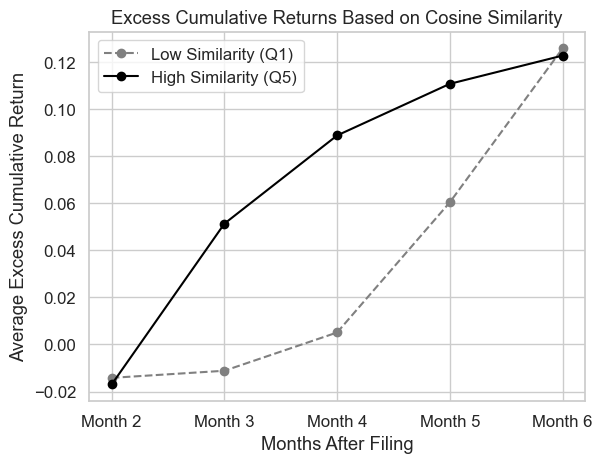

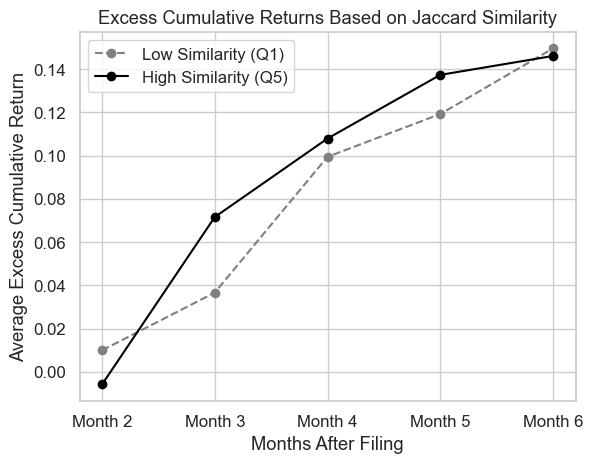

In [107]:
# Plot Motion of Excess Cumulative Returns for Quintile 5 and 1

# Define months and labels
months = [2, 3, 4, 5, 6]
x_ticks = list(range(len(months)))
x_labels = [f"Month {m}" for m in months]

# Cosine Similarity Plot
grouped_cosine = df_sims_with_prices.groupby('cosine_quintile').agg({
    "excess_cum_return_2": 'mean',
    "excess_cum_return_3": 'mean',
    "excess_cum_return_4": 'mean',
    "excess_cum_return_5": 'mean',
    "excess_cum_return_6": 'mean'
})

q1_cosine = grouped_cosine.loc[1]
q5_cosine = grouped_cosine.loc[5]

plt.plot(x_ticks, q1_cosine, marker='o', linestyle='--', label='Low Similarity (Q1)', color='grey')
plt.plot(x_ticks, q5_cosine, marker='o', linestyle='-', label='High Similarity (Q5)', color='black')
plt.title("Excess Cumulative Returns Based on Cosine Similarity")
plt.xlabel("Months After Filing")
plt.ylabel("Average Excess Cumulative Return")
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.legend()
plt.grid(True)
plt.savefig("cosine_similarity_returns.png", dpi=300)
plt.show()

# Jaccard Similarity Plot
grouped_jaccard = df_sims_with_prices.groupby('jaccard_quintile').agg({
    "excess_cum_return_2": 'mean',
    "excess_cum_return_3": 'mean',
    "excess_cum_return_4": 'mean',
    "excess_cum_return_5": 'mean',
    "excess_cum_return_6": 'mean'
})

q1_jaccard = grouped_jaccard.loc[1]
q5_jaccard = grouped_jaccard.loc[5]


plt.plot(x_ticks, q1_jaccard, marker='o', linestyle='--', label='Low Similarity (Q1)', color='grey')
plt.plot(x_ticks, q5_jaccard, marker='o', linestyle='-', label='High Similarity (Q5)', color='black')
plt.title("Excess Cumulative Returns Based on Jaccard Similarity")
plt.xlabel("Months After Filing")
plt.ylabel("Average Excess Cumulative Return")
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.legend()
plt.grid(True)
plt.savefig("jaccard_similarity_returns.png", dpi=300)
plt.show()


## 7. Regression Analysis

In [56]:
# Cosine Similarity
df_regression = df_sims_with_prices[['cosine_sim','excess_cum_return_4']].dropna()
X = sm.add_constant(df_regression['cosine_sim'])  # adds an intercept term
y = df_regression['excess_cum_return_4']/3

# Fit the OLS regression
model = sm.OLS(y, X).fit()

# Print the full regression table
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     excess_cum_return_4   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                     9.872
Date:                 Sat, 17 May 2025   Prob (F-statistic):            0.00168
Time:                         16:41:54   Log-Likelihood:                -15823.
No. Observations:                19014   AIC:                         3.165e+04
Df Residuals:                    19012   BIC:                         3.166e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6172      0.205     -3.01

In [57]:
# Jaccard Similarity
df_regression = df_sims_with_prices[['jaccard_sim','excess_cum_return_4']].dropna()
X = sm.add_constant(df_regression['jaccard_sim'])  # adds an intercept term
y = df_regression['excess_cum_return_4']/3

# Fit the OLS regression
model = sm.OLS(y, X).fit()

# Print the full regression table
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     excess_cum_return_4   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                     3.892
Date:                 Sat, 17 May 2025   Prob (F-statistic):             0.0485
Time:                         16:41:55   Log-Likelihood:                -15826.
No. Observations:                19014   AIC:                         3.166e+04
Df Residuals:                    19012   BIC:                         3.167e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0254      0.026     -0

# Exclude Outliers in Terms of Stock Return and Reanalyse

In [117]:
# Exclude 99th percentile of excess cumulative returns
# Calculate the 99th percentile threshold
df_filtered = df_sims_with_prices
threshold = df_filtered['excess_cum_return_4'].quantile(0.99)

# Filter out rows above that threshold
df_filtered = df_filtered[df_filtered['excess_cum_return_4'] <= threshold]
threshold

2.329064801588895

In [118]:
# Summary statistics for similarity measures
print(df_filtered['cosine_sim'].describe())
print('------------------------------------------')
print(df_filtered['jaccard_sim'].describe())
print('-----------------------------------------')
print('-----------------------------------------')
print('Correlation between cosine similarity and jaccard similarity measures: ', 
      df_filtered['cosine_sim'].corr(df_filtered['jaccard_sim']))

count    18823.000000
mean         0.985872
std          0.019438
min          0.560317
25%          0.984907
50%          0.993176
75%          0.996185
max          0.999925
Name: cosine_sim, dtype: float64
------------------------------------------
count    18823.000000
mean         0.680018
std          0.105579
min          0.094046
25%          0.623718
50%          0.692406
75%          0.754914
max          0.977281
Name: jaccard_sim, dtype: float64
-----------------------------------------
-----------------------------------------
Correlation between cosine similarity and jaccard similarity measures:  0.6575632837978668


In [126]:
# Calculate average monthly excess returns by cosine similarity
monthly_avg_returns = df_filtered.groupby('cosine_quintile')['excess_cum_return_4'].mean() / 3

# Print
print('Monthly Average Excess Returns of the Portfolios (Outliers Excluded):')
print('Quintile Portfolios for Cosine Measure')
print('-----------------------------------------------------------')
for quintile, avg_return in monthly_avg_returns.items():
    print(f"Quintile {quintile}: {avg_return:.4f}")

# Q5-Q1
spread = (monthly_avg_returns[5] - monthly_avg_returns[1]) * 100
print('-----------------------------------------------------------')
print(f'Q5 - Q1 Average Return Spread: {spread:.2f}%')

Monthly Average Excess Returns of the Portfolios (Outliers Excluded):
Quintile Portfolios for Cosine Measure
-----------------------------------------------------------
Quintile 1: -0.0124
Quintile 2: -0.0113
Quintile 3: -0.0028
Quintile 4: -0.0069
Quintile 5: -0.0069
-----------------------------------------------------------
Q5 - Q1 Average Return Spread: 0.55%


In [127]:
# Calculate average monthly excess returns by jaccard similarity
monthly_avg_returns = df_filtered.groupby('jaccard_quintile')['excess_cum_return_4'].mean() / 3

# Print
print('Monthly Average Excess Returns of the Portfolios (Outliers Excluded):')
print('Quintile Portfolios for Jaccard Measure')
print('-----------------------------------------------------------')
for quintile, avg_return in monthly_avg_returns.items():
    print(f"Quintile {quintile}: {avg_return:.4f}")

# Q5-Q1
spread = (monthly_avg_returns[5] - monthly_avg_returns[1]) * 100
print('-----------------------------------------------------------')
print(f'Q5 - Q1 Average Return Spread: {spread:.2f}%')

Monthly Average Excess Returns of the Portfolios (Outliers Excluded):
Quintile Portfolios for Jaccard Measure
-----------------------------------------------------------
Quintile 1: -0.0161
Quintile 2: -0.0105
Quintile 3: -0.0060
Quintile 4: -0.0037
Quintile 5: -0.0040
-----------------------------------------------------------
Q5 - Q1 Average Return Spread: 1.20%


### Regression Analysis

In [121]:
# Cosine Similarity
df_regression = df_filtered[['cosine_sim','excess_cum_return_4']].dropna()
X = sm.add_constant(df_regression['cosine_sim'])  # adds an intercept term
y = df_regression['excess_cum_return_4']

# Fit the OLS regression
model = sm.OLS(y, X).fit()

# Print the full regression table
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     excess_cum_return_4   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     21.54
Date:                 Sat, 17 May 2025   Prob (F-statistic):           3.49e-06
Time:                         18:46:48   Log-Likelihood:                -3918.4
No. Observations:                18823   AIC:                             7841.
Df Residuals:                    18821   BIC:                             7856.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5354      0.110     -4.85

In [128]:
# Jaccard Similarity
df_regression = df_filtered[['jaccard_sim','excess_cum_return_4']].dropna()
X = sm.add_constant(df_regression['jaccard_sim'])  # adds an intercept term
y = df_regression['excess_cum_return_4']

# Fit the OLS regression
model = sm.OLS(y, X).fit()

# Print the full regression table
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     excess_cum_return_4   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                  0.003
Method:                  Least Squares   F-statistic:                     49.01
Date:                 Sat, 17 May 2025   Prob (F-statistic):           2.63e-12
Time:                         18:49:25   Log-Likelihood:                -3904.7
No. Observations:                18823   AIC:                             7813.
Df Residuals:                    18821   BIC:                             7829.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1220      0.014     -8